## TAnoGAN_NGSIM: Time Series Anomaly Detection with Generative Adversarial Networks

Applied to the NGSIM-101 dataset

### Import required libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from ngsim_dataset import NGSIMDataset
# from nab_dataset import NabDataset
from models.recurrent_models_pyramid import LSTMGenerator, LSTMDiscriminator, LSTMGeneratorX

#### Define Basic Settings for Adversarial Training

In [3]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=1
    lr=0.002 # learning rate, default: 0.0002
    cuda = True
    manualSeed=2
    
opt_trn=ArgsTrn()

In [4]:
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

### Setup Data Loader

In [5]:
# location of datasets and category
# end_name = 'ambient_temperature_system_failure.csv' # dataset name
# data_file = 'data\\realKnownCause\\'+end_name # dataset category and dataset name
# key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels

In [6]:
# settings for data loader
class DataSettings:
    
    
    
    def __init__(self):
        # location of datasets and category
        end_name = 'ngsim_sample.csv' # dataset name
        data_file = end_name # dataset category and dataset name
        # key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels
        
        self.BASE = '/Users/thinhhoang/Documents/TAnoGAN/NGSIM_Dataset'
        # check if self.BASE has the last '/'
        if self.BASE[-1] != '/':
            self.BASE += '/'
        # self.label_file = 'labels\\combined_windows.json'
        self.data_file = data_file
        # self.key = key
        self.train = True
        self.window_length = 60
        self.column_name = 'Velocity'

data_settings = DataSettings()

In [7]:
# define dataset object and data loader object for NAB dataset
dataset = NGSIMDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

dataset.x.shape

Select column name: Velocity
Processed vehicle 1/200
Number of sequences processed in this iteration: 9
Processed vehicle 2/200
Number of sequences processed in this iteration: 18
Processed vehicle 3/200
Number of sequences processed in this iteration: 27
Processed vehicle 4/200
Number of sequences processed in this iteration: 36
Processed vehicle 5/200
Number of sequences processed in this iteration: 45
Processed vehicle 6/200
Number of sequences processed in this iteration: 54
Processed vehicle 7/200
Number of sequences processed in this iteration: 63
Processed vehicle 8/200
Number of sequences processed in this iteration: 72
Processed vehicle 9/200
Number of sequences processed in this iteration: 81
Processed vehicle 10/200
Number of sequences processed in this iteration: 90
Processed vehicle 11/200
Number of sequences processed in this iteration: 99
Processed vehicle 12/200
Number of sequences processed in this iteration: 108
Processed vehicle 13/200
Number of sequences processed i

torch.Size([1800, 60, 1])

In [8]:
print('Preview of a data point:')
dataset.x[0].T

Preview of a data point:


tensor([[ 0.0070,  0.0070,  0.0070,  0.0070,  0.0070,  0.0070,  0.0070,  0.0070,
          0.0070,  0.0199, -0.0144, -0.0511, -0.0803, -0.0511, -0.0146,  0.0201,
          0.0068,  0.0070,  0.0070,  0.0070,  0.0068,  0.0070,  0.0068,  0.0070,
          0.0070,  0.0070,  0.0068,  0.0070,  0.0179, -0.0053, -0.0471, -0.0657,
         -0.0473, -0.0053,  0.0174,  0.0065,  0.0068,  0.0068,  0.0065,  0.0068,
          0.0068,  0.0065,  0.0065,  0.0076,  0.0098,  0.0070, -0.0838, -0.1289,
         -0.2120, -0.1571, -0.1304, -0.0501, -0.0569, -0.0572, -0.0577, -0.0612,
         -0.0624, -0.0514, -0.0123,  0.0199]])

### Setup Models

In [9]:
# device = torch.device("cuda:0" if opt_trn.cuda else "cpu") # select the device
device = torch.device("cpu") # select the device
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature

In [10]:
print('in_dim:', in_dim)
print('seq_len:', seq_len)
print('device:', device)

in_dim: 1
seq_len: 60
device: cpu


In [11]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)
#netG = LSTMGenerator2(in_dim=in_dim, out_dim=in_dim, hidden_dim=64, n_layers=2)

In [12]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [13]:
# Setup loss function
criterion = nn.BCELoss().to(device)

In [14]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)

# Pretrain the generator

Text(0.5, 1.0, 'Training sequences')

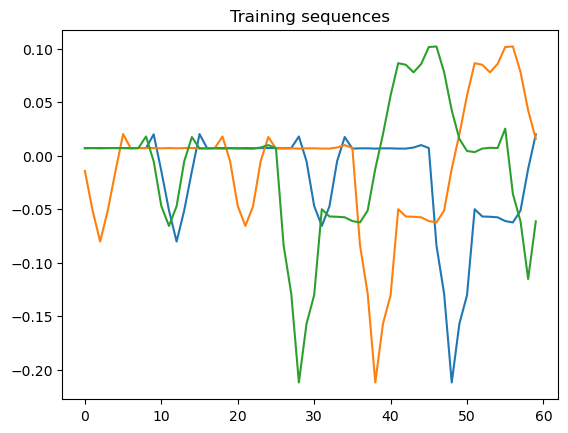

In [16]:
# Plot some sequences in the training set
import matplotlib.pyplot as plt
for i in range(3):
    plt.plot(dataset.x[i].flatten(), label=f"Sequence {i}")
plt.title("Training sequences")


# Pretrain the generator on real time series

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return output

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate training data
n_steps = 50
series = dataset.x
X_train = torch.from_numpy(series[:n_steps]).unsqueeze(0)  # Add batch dimension
y_train = torch.from_numpy(series[1:]).unsqueeze(0)  # Add batch dimension

# Create the LSTM model
input_size = 1
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
n_epochs = 200
losses = []

for epoch in range(n_epochs):
    model.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Generate predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_train)

# Convert tensors to numpy for plotting
y_train_np = y_train.squeeze().numpy()
y_pred_np = y_pred.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train_np, label='Actual')
plt.plot(y_pred_np, label='Predicted')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch [1/20], Batch [1/25], Loss before update: 0.9847
Epoch [1/20], Batch [1/25], Loss after update: 0.9852
Epoch [1/20], Batch [2/25], Loss before update: 1.0081
Epoch [1/20], Batch [2/25], Loss after update: 1.0083
Epoch [1/20], Batch [3/25], Loss before update: 1.0156
Epoch [1/20], Batch [3/25], Loss after update: 1.0156
Epoch [1/20], Batch [4/25], Loss before update: 0.9699
Epoch [1/20], Batch [4/25], Loss after update: 0.9678
Epoch [1/20], Batch [5/25], Loss before update: 1.0351
Epoch [1/20], Batch [5/25], Loss after update: 1.0330
Epoch [1/20], Batch [6/25], Loss before update: 1.0085
Epoch [1/20], Batch [6/25], Loss after update: 1.0083
Epoch [1/20], Batch [7/25], Loss before update: 1.0392
Epoch [1/20], Batch [7/25], Loss after update: 1.0396
Epoch [1/20], Batch [8/25], Loss before update: 0.9677
Epoch [1/20], Batch [8/25], Loss after update: 0.9679
Epoch [1/20], Batch [9/25], Loss before update: 0.9661
Epoch [1/20], Batch [9/25], Loss after update: 0.9653
Epoch [1/20], Batch

In [19]:
# Generate new sequences
sample_sequences = []
with torch.no_grad():
    for i in range(5):
        noise = generate_noise(1, seq_len, in_dim).to(device)
        generated_sequences, _ = trained_generator(noise)
        sample_sequences.append(generated_sequences[0].detach().cpu().numpy().flatten())

Text(0.5, 1.0, 'Generated sequences')

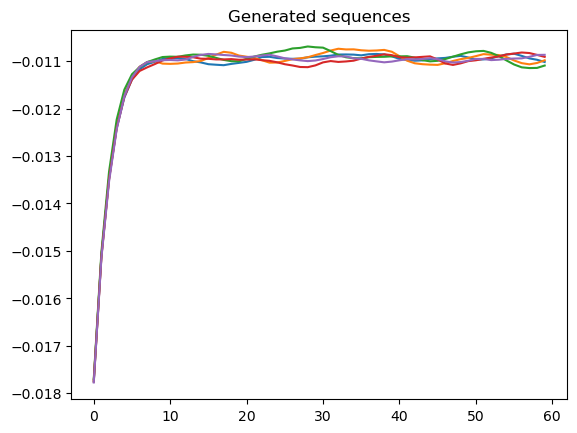

In [20]:
plt.figure()
for i, seq in enumerate(sample_sequences):
    plt.plot(seq, label=f"Sequence {i}")
plt.title("Generated sequences")


Text(0.5, 1.0, 'Training sequences')

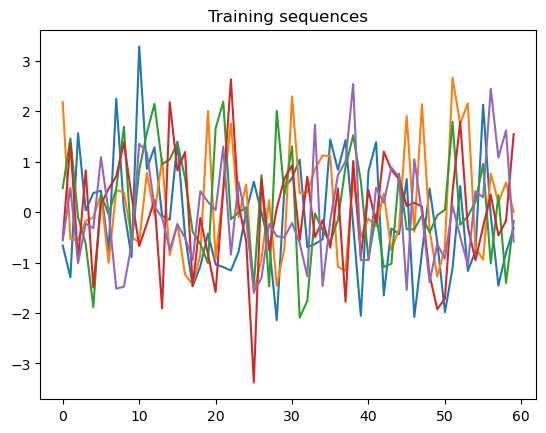

In [21]:
# Plot the first 5 sequences in the training set
plt.figure()
for i in range(5):
    plt.plot(dataset[i][0].flatten(), label=f"Sequence {i}")
plt.title("Training sequences")


### Adversarial Training of Generator and Discriminator Models

In [ ]:
real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, x in enumerate(dataloader, 0):
        # print(x)
        # raise ValueError('Stop')
        # print("Epoch: ", epoch, "Batch: ", i, end='')
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        # netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        # # print(f'Shape of real: {real.shape}')
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = torch.randn(batch_size, seq_len, in_dim)
        # noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        # print(f'Shape of noise: {noise.shape}')
        # fake, _ = netG.forward(noise)
        fake, _ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        noise = torch.randn(batch_size, seq_len, in_dim)
        fake,_ = netG.forward(noise)
        #fake = netG.forward(noise)
        label.fill_(real_label) 
        output,_ = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()

        ############################
        # Debugging # 
        ############################
        print('[%d/%d][%d/%d] Loss_G: %.4f \n' 
              % (epoch, opt_trn.epochs, i, len(dataloader),
                 errG.item()), end='')
        
        
    print('--- Epoch ---')
    # print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
    #       % (epoch, opt_trn.epochs, i, len(dataloader),
    #          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

In [ ]:
import torch
import os

def save_network_weights(network, filename, directory='saved_models'):
    """
    Save the weights of a network to a file.
    
    :param network: The network (generator or discriminator) to save
    :param filename: Name of the file to save the weights to
    :param directory: Directory to save the weights in
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)
    torch.save(network.state_dict(), filepath)
    print(f"Network weights saved to {filepath}")

def save_gan_weights(netG, netD, gen_filename='generator_weights.pth', disc_filename='discriminator_weights.pth', directory='saved_models'):
    """
    Save the weights of both the generator and discriminator networks.
    
    :param netG: The generator network
    :param netD: The discriminator network
    :param gen_filename: Filename for the generator weights
    :param disc_filename: Filename for the discriminator weights
    :param directory: Directory to save the weights in
    """
    save_network_weights(netG, gen_filename, directory)
    save_network_weights(netD, disc_filename, directory)

# Example usage:
# Assuming you have your trained generator as 'netG' and discriminator as 'netD'
save_gan_weights(netG, netD)

# If you want to save with custom filenames or to a specific directory:
# save_gan_weights(netG, netD, gen_filename='my_generator.pth', disc_filename='my_discriminator.pth', directory='my_models')

# To save just one network:
# save_network_weights(netG, 'generator_final.pth')

# Inspection

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def generate_samples(netG, num_samples=1, seq_len=60, in_dim=1, device='cuda'):
    """
    Generate samples using the trained generator.
    
    :param netG: The trained generator network
    :param num_samples: Number of samples to generate
    :param seq_len: Sequence length of the generated samples
    :param in_dim: Input dimension for the generator
    :param device: Device to run the generator on ('cuda' or 'cpu')
    :return: Generated samples
    """
    netG.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        noise = torch.randn(num_samples, seq_len, in_dim, device=device)
        # generated_samples, _ = netG(noise)
        generated_samples, _ = netG(noise)
    return generated_samples.cpu().numpy()

def plot_samples(samples, num_samples=1):
    """
    Plot the generated samples.
    
    :param samples: Generated samples
    :param num_samples: Number of samples to plot
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 3*num_samples))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        axes[i].plot(samples[i])
        axes[i].set_title(f'Sample {i+1}')
        axes[i].set_xlabel('Sequence')
        axes[i].set_ylabel('Value')
    plt.tight_layout()
    plt.show()

# Assuming you have your trained generator as 'netG'
# and it's on the GPU (change to 'cpu' if using CPU)
device = 'cpu'

# Generate samples
samples = generate_samples(netG, num_samples=1, seq_len=60, in_dim=1, device=device)

# Plot the first 5 samples
plot_samples(samples, num_samples=1)

print('Average of last 10 samples:', samples[0][-10:].mean(), '+-', samples[0][-10:].std())

# You can also save the samples to a file if needed
#np.save('generated_samples.npy', samples)
#print("Samples saved to 'generated_samples.npy'")

In [ ]:
def plot_velocity_traces(dataset, n=20):
    plt.figure(figsize=(10, 6)) 
    for i in range(n):
        plt.plot(dataset.x[i], label=f'Trajectory {i+1}')

plot_velocity_traces(dataset, n=20)

## Anomaly Detection

#### Define basic settings for inverse mapping

In [ ]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()    

In [ ]:
generator = netG # changing reference variable 
discriminator = netD # changing reference variable 

##### Define Test Data

In [ ]:
# Define settings for loading data in evaluation mood
class TestDataSettings:
    
    def __init__(self):
        end_name = 'ngsim_test.csv' # dataset name
        data_file = end_name # dataset category and dataset name
        # key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels
        
        self.BASE = '/Users/thinhhoang/Documents/TAnoGAN/NGSIM_Dataset'
        # check if self.BASE has the last '/'
        if self.BASE[-1] != '/':
            self.BASE += '/'
        # self.label_file = 'labels\\combined_windows.json'
        self.data_file = data_file
        self.train = False
        self.column_name = 'Local_Y'

        
test_data_settings = TestDataSettings()


In [ ]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = NGSIMDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.data_len # check the dataset shape

#### Define a function to calculate anomaly score

In [ ]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

### Inverse mapping to latent space and reconstruction of data for estimating anomaly score

In [ ]:
loss_list = []
#y_list = []
for i, x in enumerate(test_dataloader):
    print('Processing data {}/{}'.format(i+1, len(test_dataloader)))
    
    z = Variable(init.normal(torch.zeros(opt_test.batch_size,
                                     test_dataset.window_length, 
                                     test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z)
        loss = Anomaly_score(Variable(x), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y= -.- ~~~~~~~~~~'.format(loss))
    #break

### Visualise Anomaly Detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 12.2 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
# test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
# plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
import seaborn as sns

anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  range(test_dataset.data_len), 
  test_score_df['t'], 
  label='value'
);

sns.scatterplot(
  anomalies.index,
  anomalies.t,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.plot(
  range(len(test_score_df['y'])),
  test_score_df['y'],
  label='y'
)

plt.xticks(rotation=25)
plt.legend();

### Calculate the window-based anomalies

In [ ]:
import numpy as np
start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1
            
actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

### Calculate measurement scores

In [ ]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = (2 * precision * recall) / (precision + recall)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

In [ ]:
# import winsound
# frequency = 200  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)